# Load libraries

In [1]:

# General libraries
import numpy as np               
import pandas as pd              
import h2o                       
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram # For Admissible AI, works for classification only. https://docs.h2o.ai/h2o/latest-stable/h2o-docs/admissible.html
import logging
from matplotlib import pyplot as plt


# Custom libraries
from shared_core_data_processing import * 
from spec_core_data_processing import *
from shared_core_h2o_modelling import * 

from shared_testing_data_processing import * 
from spec_testing_data_processing import *


# Other setup configurations
logger = logging.getLogger()
logger.setLevel(logging.INFO)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


# Test custom libraries

In [2]:

## Test shared function ds_common_pandas_dataframe_split_main
run_unit_test_00_ds_common_pandas_dataframe_split_main()

## Test spec function extract_expiring_minutes
run_unit_test_00_extract_expiring_minutes()


INFO:root:Achieved metrics convergence at seed 1 and iteration 1
INFO:root: 
INFO:root:########################
INFO:root:Start unit tests for function extract_expiring_minutes
INFO:root:########################
INFO:root:End unit tests for function extract_expiring_minutes. Number of errors: 0
INFO:root: 


# Define Processing, Training and Model output parameters

In [3]:

# Processing parameters
local_path_input          = 'USA_cars_datasets.csv'

# Modelling parameters
lst_features_categorical = ['brand', 'model', 'title_status', 'state', 'country', 'color']
lst_features_numerical   = ['year', 'mileage', 'condition']
str_target_variable      = 'price'
int_seed                 = 20                                
str_data_id              = 'data_id'
str_path_df_processed    = 'df_processed.parquet'

# Train/test and CV split parameters
dict_metrics              = {'price': ['mean']}
dict_metrics_tolerance    = {'price_mean': 0.01}
int_max_number_iterations = 500
dict_splits               = {'train': 0.75, 'test': 0.25}
dict_splits_cv            = {'1': 0.20, '2': 0.20, '3': 0.20, '4': 0.20, '5': 0.20} # Remark: H2O wants the CV fold column levels to be 1, 2, ...
str_colname_split         = 'flag_split_train_test'
str_colname_split_cv      = 'flag_split_folds'

# Training parameters
dict_h2o_automl = {
                   'max_models':         10, 
                   'max_runtime_secs':   600,    # 10 Minutes
                   'seed':               int_seed,
                   'sort_metric':        'RMSE',
                   'stopping_tolerance': 0.001,
                   'exclude_algos':      ['XGBoost'], # Not available on windows
                   'exploitation_ratio': 0.1
                  }

dict_h2o_init = {"nthreads": 1}

# H2O output parameters
dict_h2o_process_automl = {
                           'str_tag_data_experiment':  'data_experiment_0'
                           ,'str_tag_model_experiment': 'model_experiment_0'
    

                           ,'list_performance_metrics_regression_lb': ['mse', 'mae']
                           ,'list_other_metrics_lb':                 ['training_time_ms', 'predict_time_per_row_ms', 'algo', 'model_id']
                           
    
                           # The following lists are taken from https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
                           # They are the only hyperparameters searched by H2O Automl
                           ,'list_hyperparams_gbm': ['col_sample_rate', 'col_sample_rate_per_tree',
                                                     'max_depth', 'min_rows', 'min_split_improvement',
                                                     'ntrees', 'sample_rate']
    
                           ,'list_hyperparams_xgb': ['booster', 'col_sample_rate', 'col_sample_rate_per_tree',
                                                     'max_depth', 'min_rows', 'ntrees', 'sample_rate',
                                                     'reg_alpha', 'reg_lambda']    
    
                           ,'list_hyperparams_deeplearning': ['epochs', 'epsilon', 'hidden', 'hidden_dropout_ratios',
                                                             'input_dropout_ratio', 'rho'] 
                          }


# Main processing

In [4]:

### Data processing
## Load data
df = pd.read_csv(local_path_input)

## Extract expiring minutes
df['condition'] = df['condition'].map(lambda x: extract_expiring_minutes(x))

## Create data id column
df[str_data_id] = df.index


### Data split
## Add train/test and CV split columns
# Train/test split column
list_input_columns       = [key for key in dict_metrics.keys()] + [str_data_id]
df_split_col             = ds_common_pandas_dataframe_split_main(df[list_input_columns].copy(), str_colname_split , dict_splits, dict_metrics, dict_metrics_tolerance, int_seed, int_max_number_iterations)
df                       = pd.merge(left = df, right = df_split_col[[str_data_id , str_colname_split]], how = "left", on = 'data_id')

# CV split column (remark: it must be done on training set only)
list_input_columns       = [key for key in dict_metrics.keys()] + [str_data_id]
df_split_col_cv          = ds_common_pandas_dataframe_split_main(df[df[str_colname_split]=='train'][list_input_columns].copy(), str_colname_split_cv , dict_splits_cv, dict_metrics, dict_metrics_tolerance, int_seed, int_max_number_iterations)
df                       = pd.merge(left = df, right = df_split_col_cv[[str_data_id , str_colname_split_cv]], how = "left", on = 'data_id')
df[str_colname_split_cv] = df[str_colname_split_cv].map(lambda x: 'missing' if pd.isnull(x) else x)


### Handle schema (optional, TODO)


### Save processed file
df.to_parquet(str_path_df_processed, compression = 'gzip', index = False)


## Remove constant features from list of explanatory features
lst_features = ds_common_get_list_model_features_main(df, lst_features_numerical + lst_features_categorical)

del df


INFO:root:Achieved metrics convergence at seed 26 and iteration 7
INFO:root:Warning: metrics did not converge, last iteration metrics are {'price_mean': [0.06943444754200545, 0.01]}
INFO:root:Using the last iteration split
INFO:root:Df has the following constant features: []


# H2O Modeling - Training

In [5]:

## Process train and test sets
df_h2o_train, df_h2o_test = ds_common_h2o_data_preparation_main(str_path_df_processed, dict_h2o_init, str_colname_split, str_colname_split_cv, str_target_variable)


## Fit H2O Automl on train set
aml = H2OAutoML(**dict_h2o_automl)
aml.train(x=lst_features, y=str_target_variable, training_frame=df_h2o_train, fold_column = str_colname_split_cv)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\david\anaconda3\envs\test\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\david\AppData\Local\Temp\tmp7rby72wb
  JVM stdout: C:\Users\david\AppData\Local\Temp\tmp7rby72wb\h2o_david_started_from_python.out
  JVM stderr: C:\Users\david\AppData\Local\Temp\tmp7rby72wb\h2o_david_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_david_mvcigt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.762 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


INFO:root:Train vs test target variable mean:     18769.669185105253 vs 18761.941176470602
INFO:root:Train vs test target variable variance: 149831594.49363422 vs 138321938.14227074


AutoML progress: |
00:02:24.181: Fold column flag_split_folds will be used for cross-validation. nfolds parameter will be ignored.
00:02:24.189: Stopping tolerance set by the user is < 70% of the recommended default of 0.02323069967623409, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20220425_00224

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 10087639.305876115
RMSE: 3176.104423011957
MAE: 1928.7831883637632
RMSLE: NaN
R^2: 0.932637130176313
Mean Residual Deviance: 10087639.305876115
Null degrees of freedom: 1852
Residual degrees of freedom: 1843
Null deviance: 277488113002.2109
Residual deviance: 18692395633.78844
AIC: 35163.586260512115

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-valid

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,3.987916e+03,3.015557e+02,4.108495e+03,4.456588e+03,3.705499e+03,3.871360e+03,3.797637e+03
1,mean_residual_deviance,4.275885e+07,9.710424e+06,4.497204e+07,5.515938e+07,3.044106e+07,4.727367e+07,3.594810e+07
2,mse,4.275885e+07,9.710424e+06,4.497204e+07,5.515938e+07,3.044106e+07,4.727367e+07,3.594810e+07
3,null_deviance,5.553904e+10,6.782848e+09,6.107925e+10,5.861223e+10,4.575549e+10,6.099685e+10,5.125136e+10
4,r2,7.167332e-01,3.590756e-02,7.216822e-01,6.605621e-01,7.542866e-01,7.081720e-01,7.389632e-01
5,residual_deviance,1.582537e+10,3.452047e+09,1.699943e+10,1.974706e+10,1.123275e+10,1.777490e+10,1.337269e+10
6,rmse,6.504331e+03,7.521019e+02,6.706120e+03,7.426936e+03,5.517342e+03,6.875585e+03,5.995673e+03
7,rmsle,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN


# H2O Modelling - Explore

In [6]:

# Extract Automl info
df_output_info, df_output_varimp  = ds_common_h2o_process_automl_main(aml, df_h2o_train, df_h2o_test, dict_h2o_process_automl)


In [7]:

## View MSE CV / train / Test 
# Comment 1: test metrics has roughly almost the same rank of the CV metric (good, considering there are only 2k observations)
# Comment 2: the GLM does not overfit (train mse < cv mse), the majority of the other models overfits. Not all GBMs overfit.
df_output_info[['model_id', 'mse_lb', 'mse_train', 'mse_test']]


,model_id,mse_lb,mse_train,mse_test
0,StackedEnsemble_AllModels_1_AutoML_1_20220425_00224,4.284632e+07,1.008764e+07,2.969044e+07
0,StackedEnsemble_BestOfFamily_1_AutoML_1_20220425_00224,4.303169e+07,9.969944e+06,2.980169e+07
0,GBM_lr_annealing_selection_AutoML_1_20220425_00224_select_model,4.437748e+07,1.165815e+07,3.129346e+07
0,GBM_3_AutoML_1_20220425_00224,4.456542e+07,1.064190e+07,3.230012e+07
0,GBM_4_AutoML_1_20220425_00224,4.475026e+07,8.415295e+06,3.133194e+07
0,GBM_5_AutoML_1_20220425_00224,4.526330e+07,7.570855e+06,3.010504e+07
0,DRF_1_AutoML_1_20220425_00224,4.621209e+07,6.621302e+06,3.061017e+07
0,GBM_1_AutoML_1_20220425_00224,4.724732e+07,2.255650e+07,3.629443e+07
0,GBM_grid_1_AutoML_1_20220425_00224_model_1,4.740145e+07,2.562848e+07,3.473487e+07
0,DeepLearning_1_AutoML_1_20220425_00224,6.496594e+07,5.909493e+07,6.603309e+07


### Plot GBM models correlation between complexity (max_depth) vs CV metric

In [8]:

df_output_info_gbm = df_output_info[df_output_info['algo']=='GBM'].copy()
df_output_info_gbm


,tag_data_experiment,tag_model_experiment,model_id,algo,mse_lb,mae_lb,training_time_ms,predict_time_per_row_ms,mean_cv_mae,mean_cv_mse,sd_cv_mae,sd_cv_mse,cv_1_valid_mae,cv_1_valid_mse,cv_2_valid_mae,cv_2_valid_mse,cv_3_valid_mae,cv_3_valid_mse,cv_4_valid_mae,cv_4_valid_mse,cv_5_valid_mae,cv_5_valid_mse,min_cv_value_mae,min_cv_value_mse,max_cv_value_mae,max_cv_value_mse,mse_train,mae_train,mse_test,mae_test,col_sample_rate,col_sample_rate_per_tree,max_depth,min_rows,min_split_improvement,ntrees,sample_rate,number_variables,number_features,epochs,epsilon,hidden,hidden_dropout_ratios,input_dropout_ratio,rho,alpha,lambda
0,data_experiment_0,model_experiment_0,GBM_lr_annealing_selection_AutoML_1_20220425_00224_select_model,GBM,4.437748e+07,4014.957376,930,0.099257,4017.6719,44436216.0,329.174,10084512.0,4176.246,46753500.0,4506.8184,57175064.0,3686.364,31491298.0,3927.2466,49268828.0,3791.6843,37492404.0,3686.364,31491298.0,4506.8184,57175064.0,1.165815e+07,1937.203536,3.129346e+07,3736.973494,0.8,0.8,7.0,10.0,0.00001,114.0,0.8,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,data_experiment_0,model_experiment_0,GBM_3_AutoML_1_20220425_00224,GBM,4.456542e+07,3982.566912,645,0.053523,3984.0747,44708060.0,281.90784,9911796.0,4211.9995,47980756.0,4344.8345,56676900.0,3698.251,31842916.0,3896.8066,49464420.0,3768.482,37575300.0,3698.251,31842916.0,4344.8345,56676900.0,1.064190e+07,1818.063737,3.230012e+07,3740.305878,0.8,0.8,8.0,10.0,0.00001,64.0,0.8,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,data_experiment_0,model_experiment_0,GBM_4_AutoML_1_20220425_00224,GBM,4.475026e+07,3997.838305,694,0.070062,4012.3455,44984640.0,292.26205,10110834.0,4234.6777,48382764.0,4400.7417,57629444.0,3737.6433,32615558.0,3913.131,49382088.0,3775.5327,36913344.0,3737.6433,32615558.0,4400.7417,57629444.0,8.415295e+06,1618.854692,3.133194e+07,3758.678524,0.8,0.8,10.0,10.0,0.00001,60.0,0.8,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,data_experiment_0,model_experiment_0,GBM_5_AutoML_1_20220425_00224,GBM,4.526330e+07,3994.185600,339,0.054074,3994.4285,45512180.0,261.71338,9924924.0,4174.8066,48826044.0,4341.67,57754792.0,3688.7036,32681898.0,3920.7407,49842108.0,3846.2217,38456060.0,3688.7036,32681898.0,4341.67,57754792.0,7.570855e+06,1649.858956,3.010504e+07,3618.085020,0.8,0.8,6.0,1.0,0.00001,73.0,0.8,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,data_experiment_0,model_experiment_0,GBM_1_AutoML_1_20220425_00224,GBM,4.724732e+07,4300.358458,1184,0.088165,4307.719,47448180.0,222.46753,8805305.0,4484.9424,52015776.0,4591.9346,57858756.0,4100.23,35612208.0,4108.3433,50111684.0,4253.147,41642488.0,4100.23,35612208.0,4591.9346,57858756.0,2.255650e+07,2825.757616,3.629443e+07,4007.701803,0.8,0.8,15.0,100.0,0.00001,123.0,0.8,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,data_experiment_0,model_experiment_0,GBM_grid_1_AutoML_1_20220425_00224_model_1,GBM,4.740145e+07,4305.918793,558,0.069343,4304.7783,47449688.0,219.76758,9275501.0,4523.253,53473884.0,4512.6865,55574900.0,4000.0837,33834724.0,4212.3804,52489048.0,4275.489,41875880.0,4000.0837,33834724.0,4523.253,55574900.0,2.562848e+07,3081.286927,3.473487e+07,4004.924765,0.4,1.0,4.0,100.0,0.00001,129.0,0.8,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


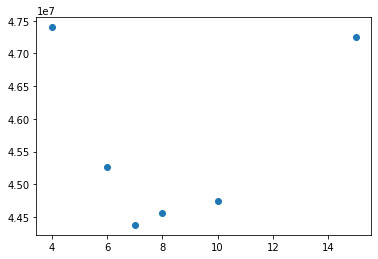

In [9]:

# There is a nice U-shaped correlation between max_depth and CV MSE.
plt.scatter(df_output_info_gbm['max_depth'],df_output_info_gbm['mse_lb'])


# Explain H2O Automl object

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20220425_00224,6545.71,4.28463e+07,3986.76,nan,4.28463e+07,1649,0.605507,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220425_00224,6559.85,4.30317e+07,4015.82,nan,4.30317e+07,1525,0.281057,StackedEnsemble
GBM_lr_annealing_selection_AutoML_1_20220425_00224_select_model,6661.64,4.43775e+07,4014.96,nan,4.43775e+07,930,0.099257,GBM
GBM_3_AutoML_1_20220425_00224,6675.73,4.45654e+07,3982.57,nan,4.45654e+07,645,0.053523,GBM
GBM_4_AutoML_1_20220425_00224,6689.56,4.47503e+07,3997.84,nan,4.47503e+07,694,0.070062,GBM
GBM_5_AutoML_1_20220425_00224,6727.8,4.52633e+07,3994.19,nan,4.52633e+07,339,0.054074,GBM
DRF_1_AutoML_1_20220425_00224,6797.95,4.62121e+07,4036.46,1.07933,4.62121e+07,918,0.058011,DRF
GBM_1_AutoML_1_20220425_00224,6873.67,4.72473e+07,4300.36,nan,4.72473e+07,1184,0.088165,GBM
GBM_grid_1_AutoML_1_20220425_00224_model_1,6884.87,4.74014e+07,4305.92,nan,4.74014e+07,558,0.069343,GBM
DeepLearning_1_AutoML_1_20220425_00224,8060.15,6.49659e+07,5581.4,nan,6.49659e+07,802,0.022136,DeepLearning


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

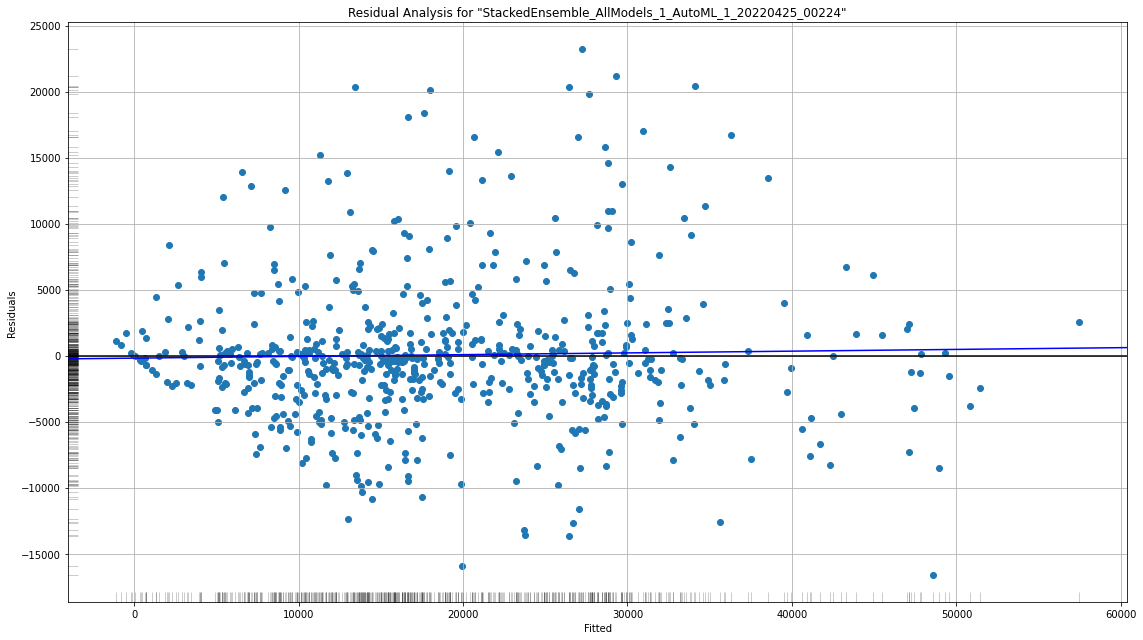

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

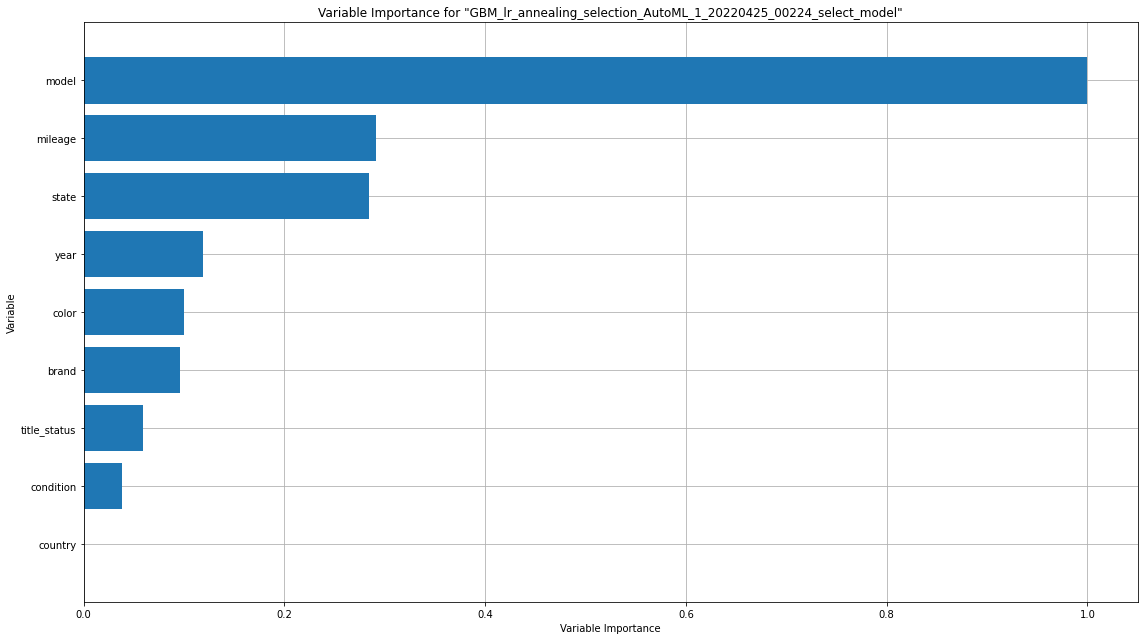

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

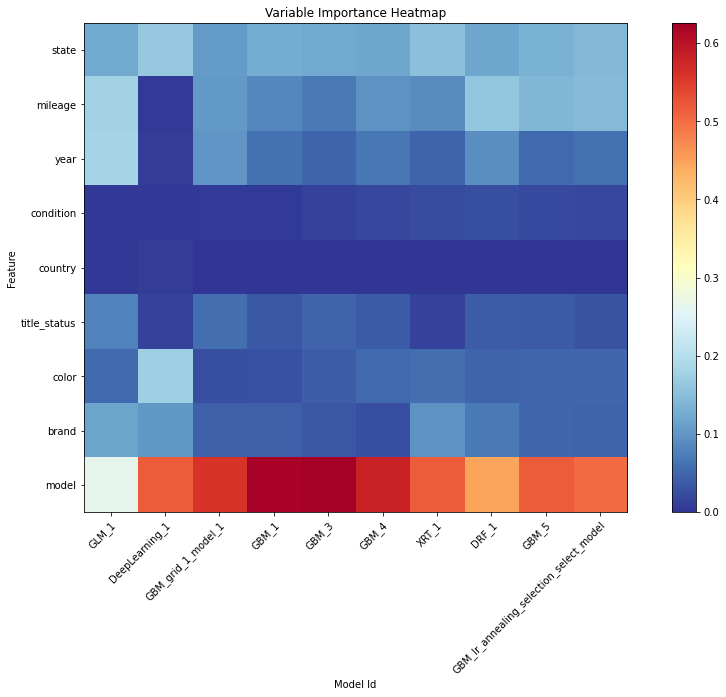

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

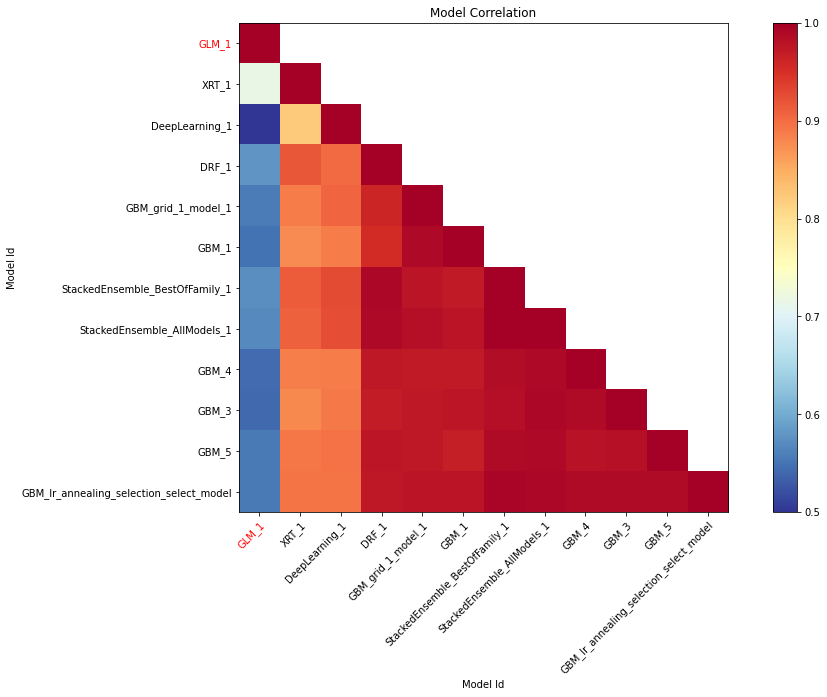

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

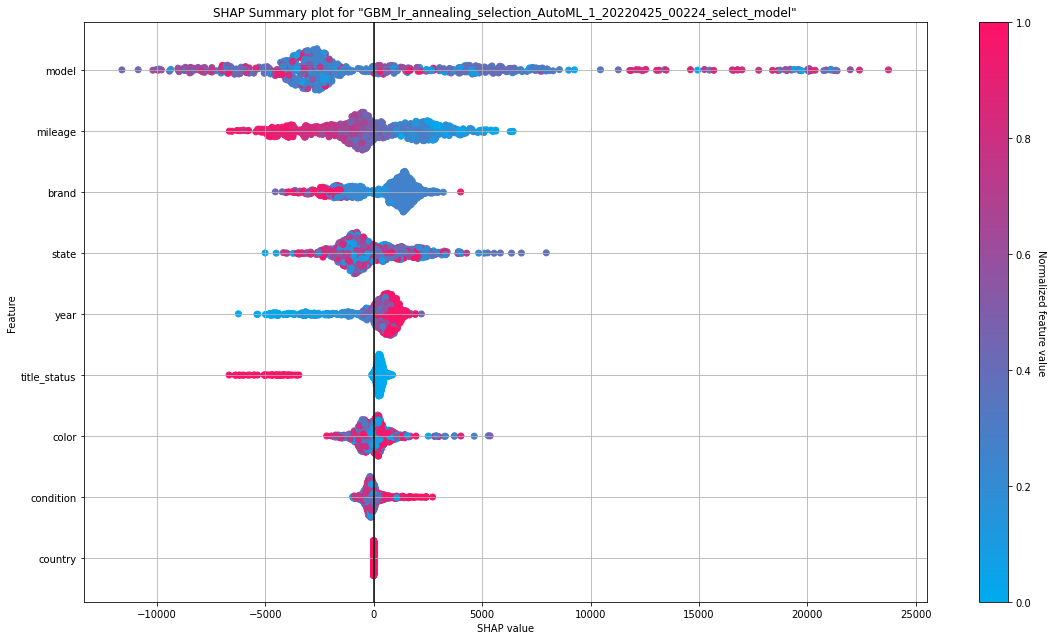

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

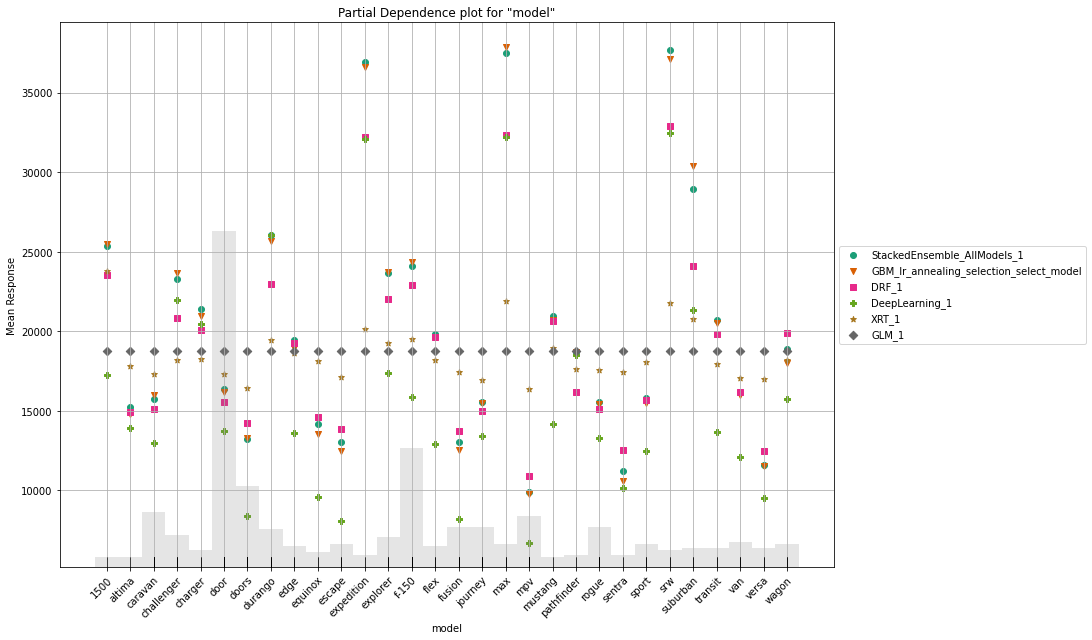

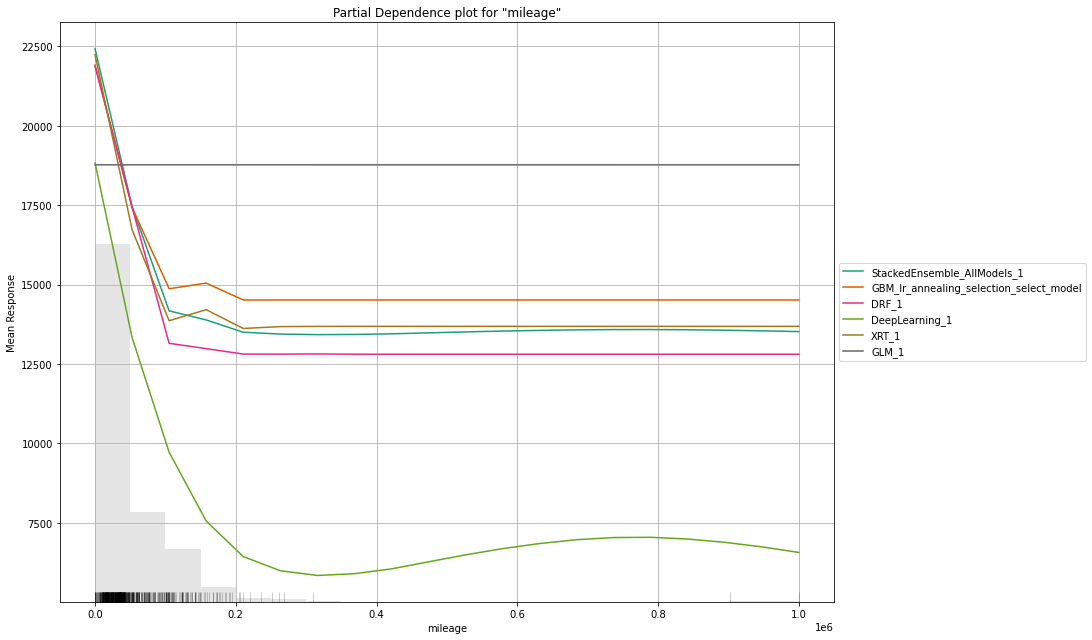

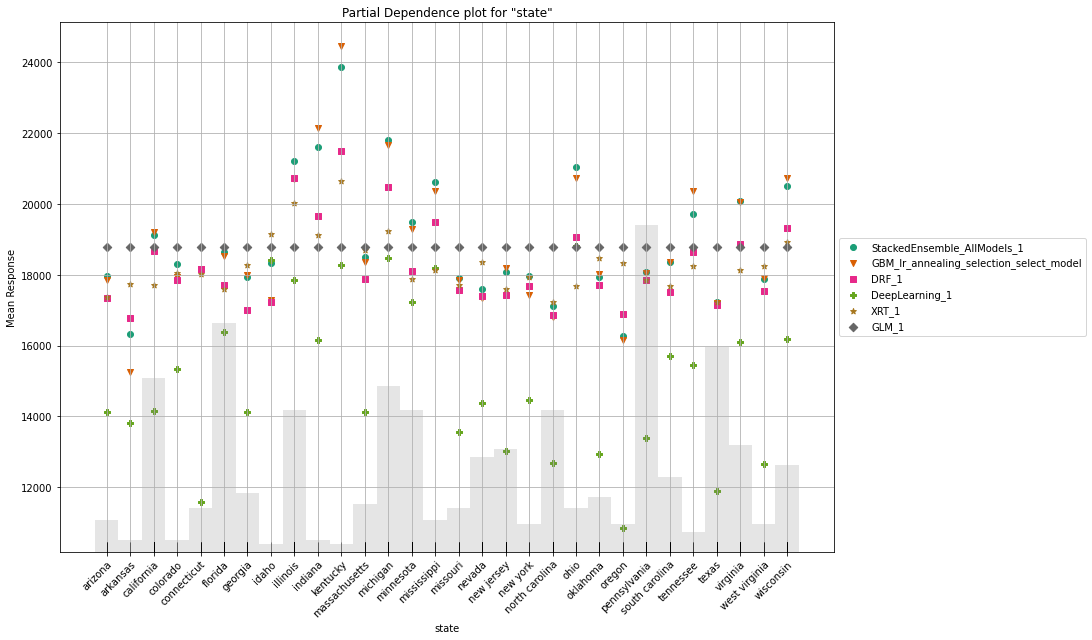

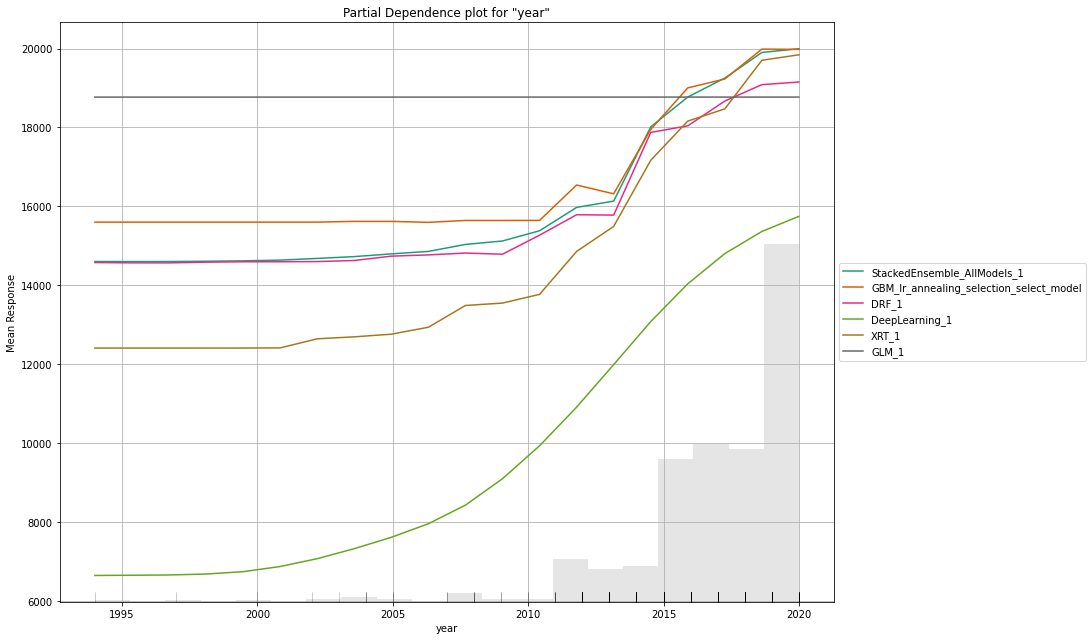

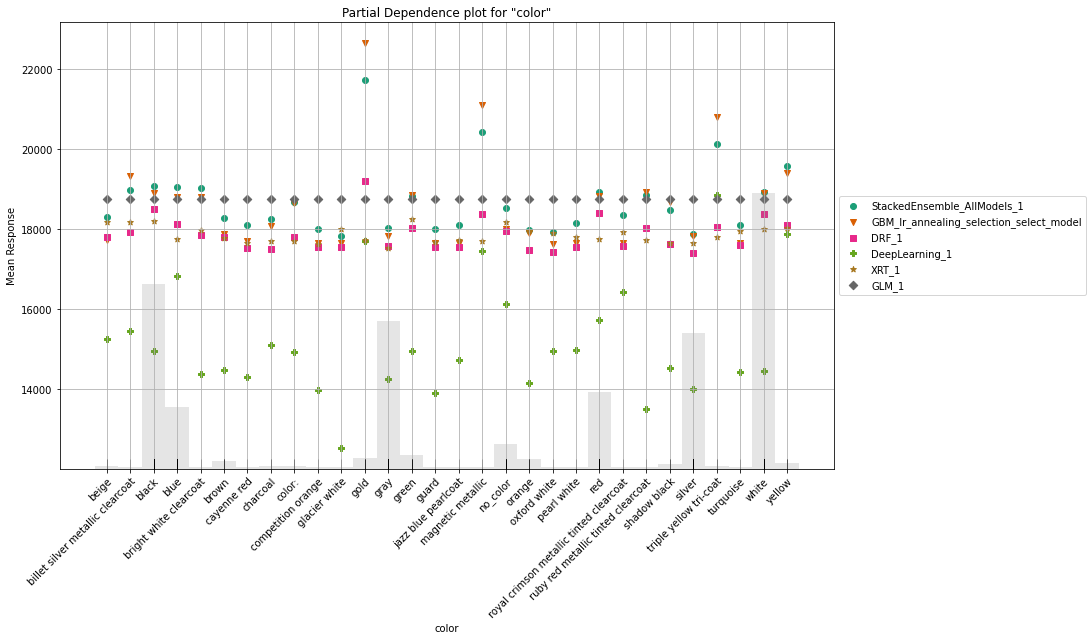

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

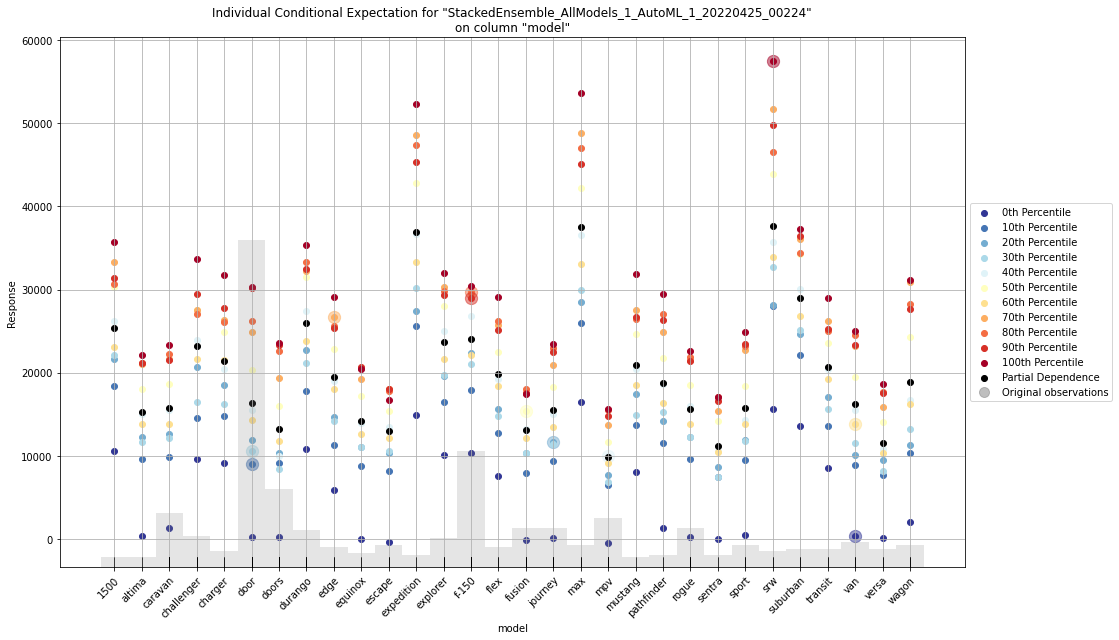

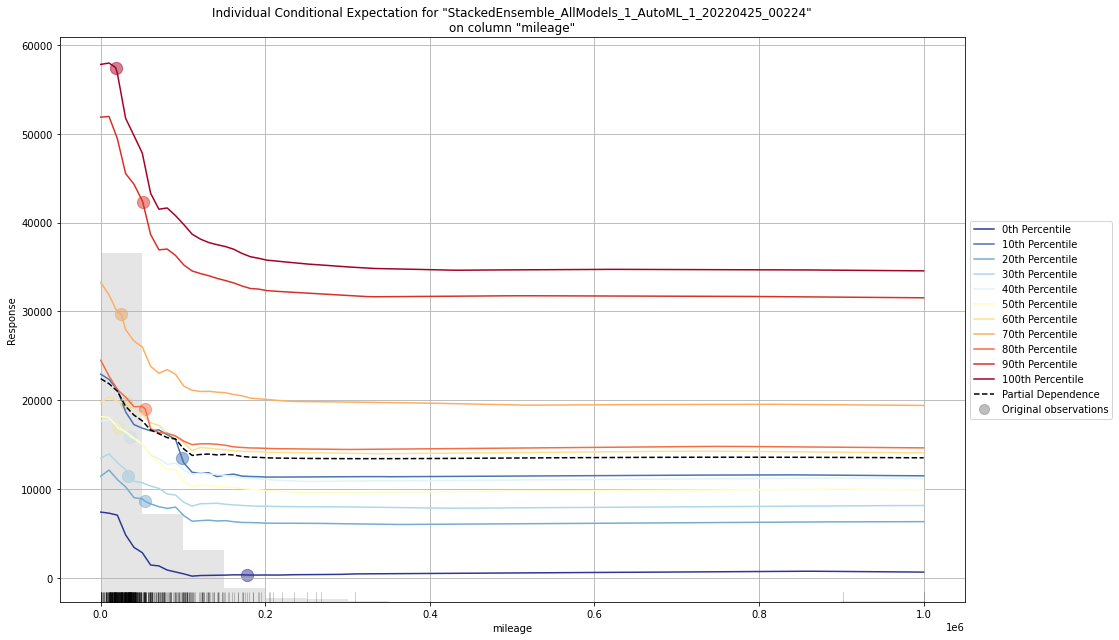

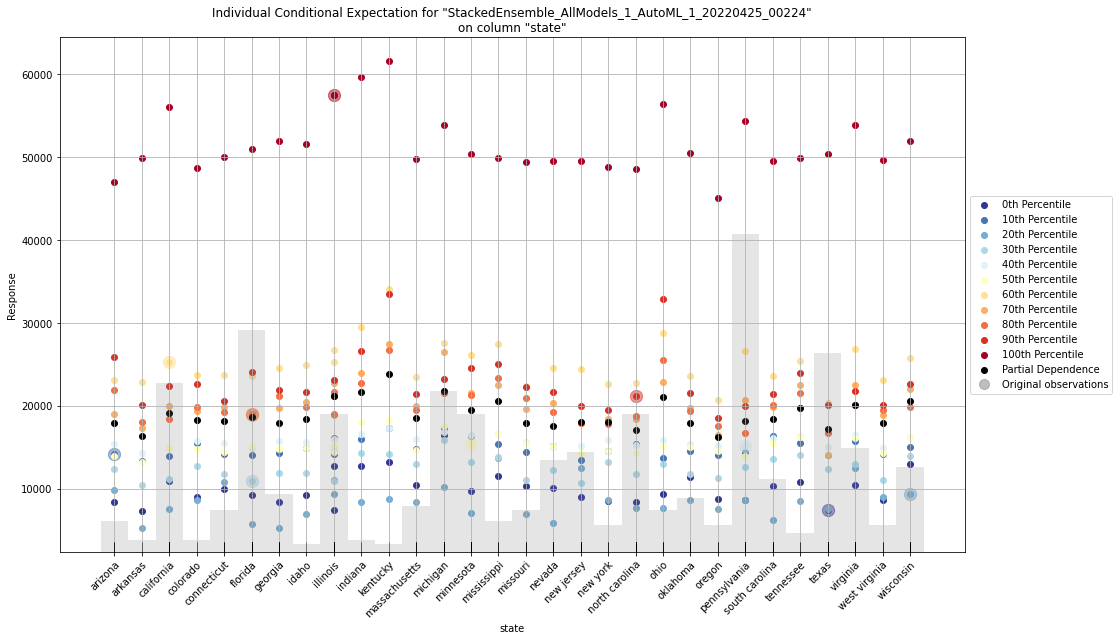

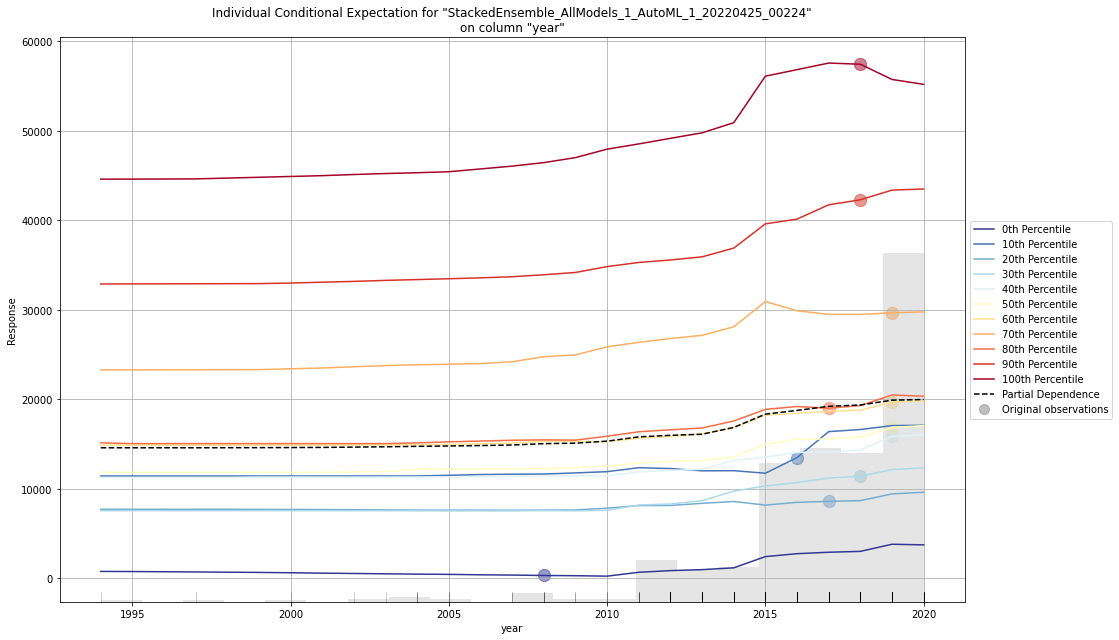

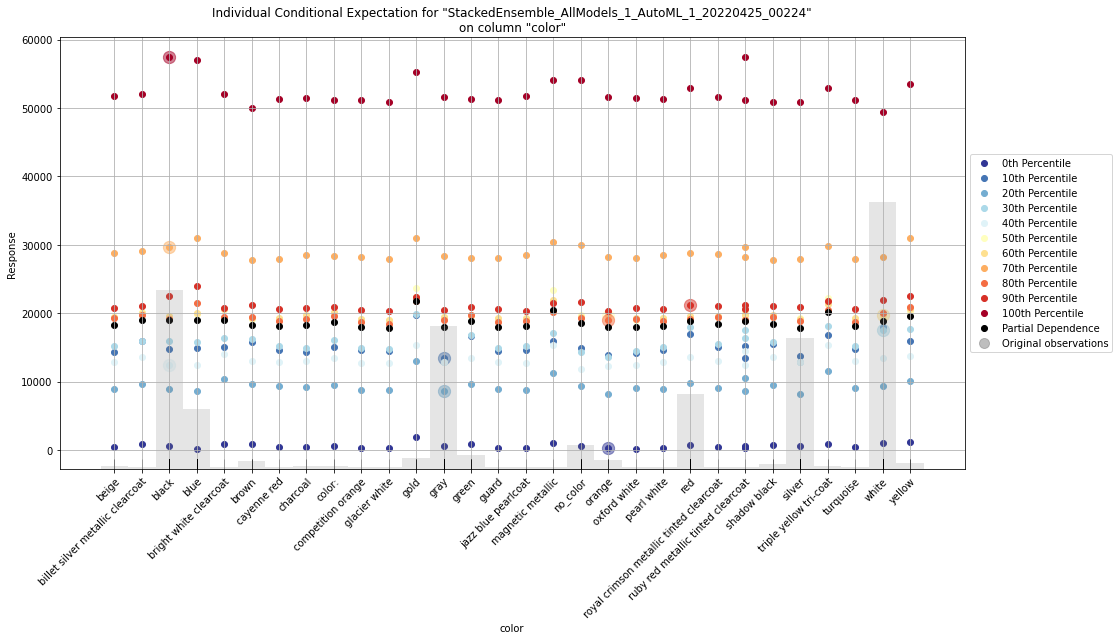

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20220425_00224,6545.71,4.28463e+07,3986.76,nan,4.28463e+07,1649,0.605507,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220425_00224,6559.85,4.30317e+07,4015.82,nan,4.30317e+07,1525,0.281057,StackedEnsemble
GBM_lr_annealing_selection_AutoML_1_20220425_00224_select_model,6661.64,4.43775e+07,4014.96,nan,4.43775e+07,930,0.099257,GBM
GBM_3_AutoML_1_20220425_00224,6675.73,4.45654e+07,3982.57,nan,4.45654e+07,645,0.053523,GBM
GBM_4_AutoML_1_20220425_00224,6689.56,4.47503e+07,3997.84,nan,4.47503e+07,694,0.070062,GBM
GBM_5_AutoML_1_20220425_00224,6727.8,4.52633e+07,3994.19,nan,4.52633e+07,339,0.054074,GBM
DRF_1_AutoML_1_20220425_00224,6797.95,4.62121e+07,4036.46,1.07933,4.62121e+07,918,0.058011,DRF
GBM_1_AutoML_1_20220425_00224,6873.67,4.72473e+07,4300.36,nan,4.72473e+07,1184,0.088165,GBM
GBM_grid_1_AutoML_1_20220425_00224_model_1,6884.87,4.74014e+07,4305.92,nan,4.74014e+07,558,0.069343,GBM
DeepLearning_1_AutoML_1_20220425_00224,8060.15,6.49659e+07,5581.4,nan,6.49659e+07,802,0.022136,DeepLearning


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [10]:

aml.explain(df_h2o_test)


# Top Non-SE Model analysis - Explainability

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

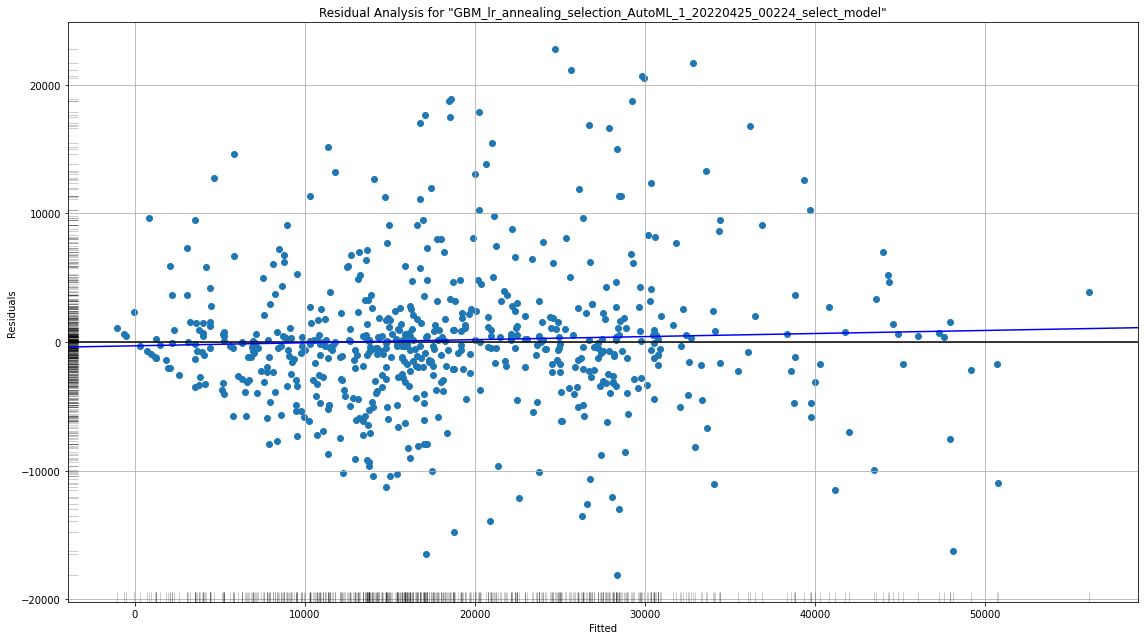

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

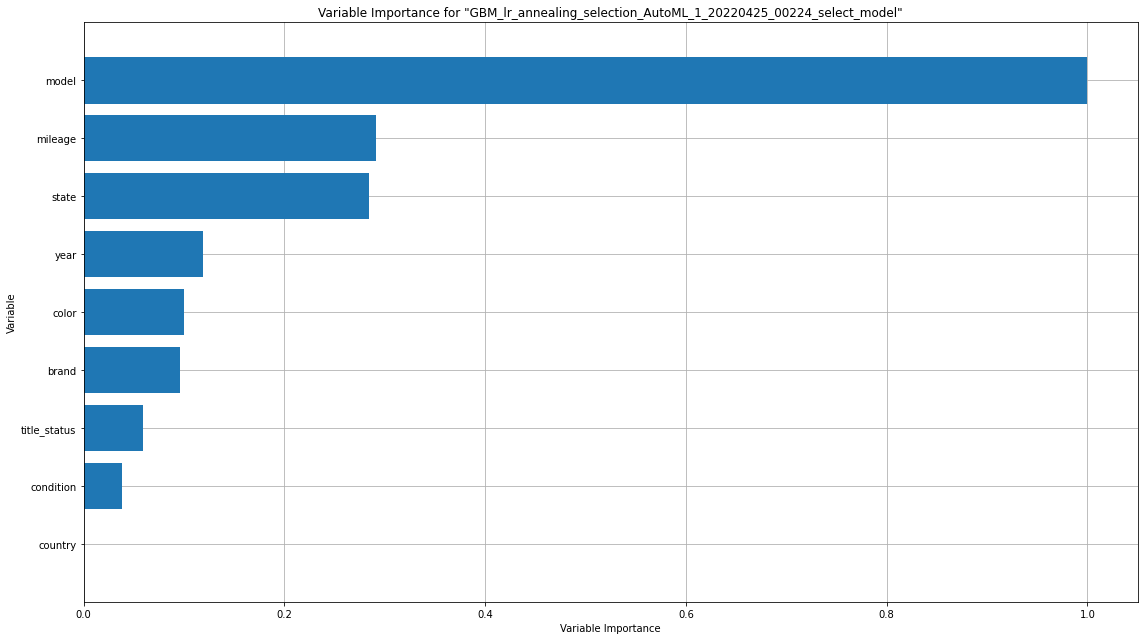

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

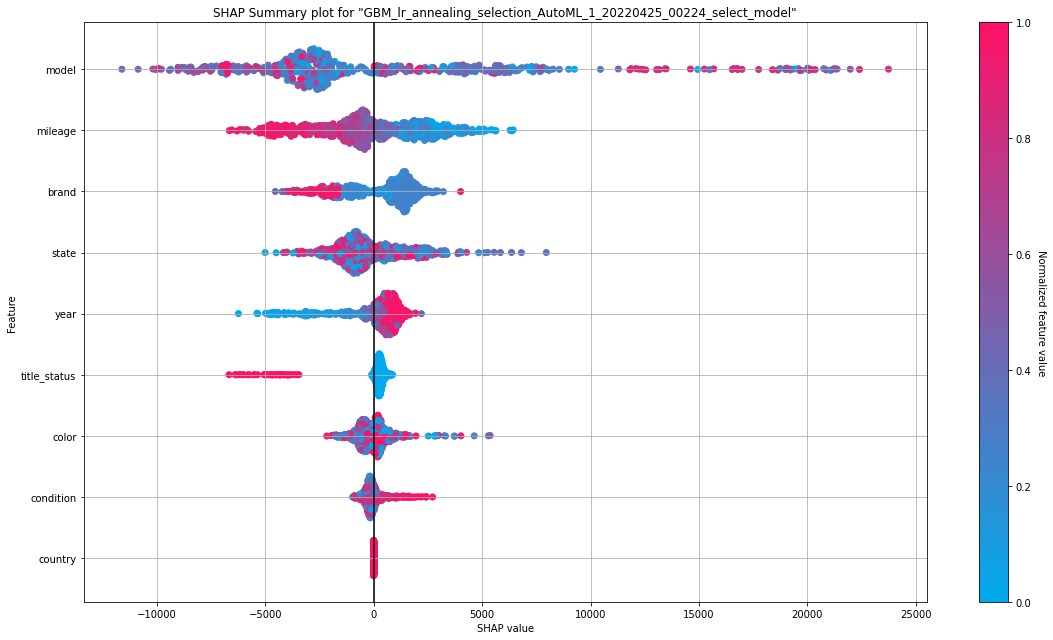

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

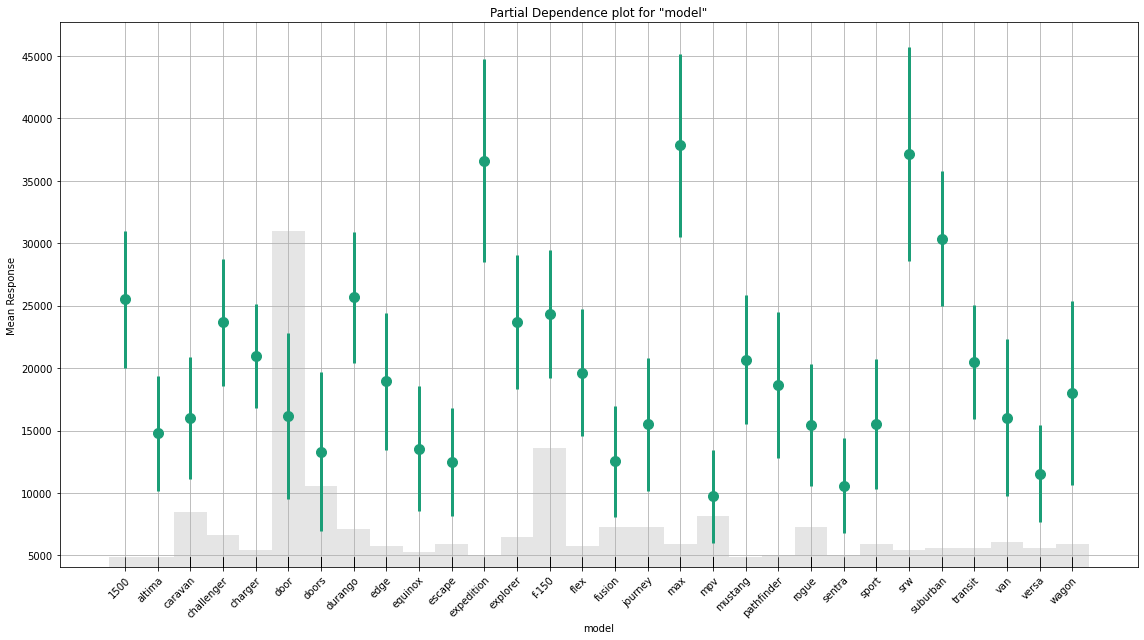

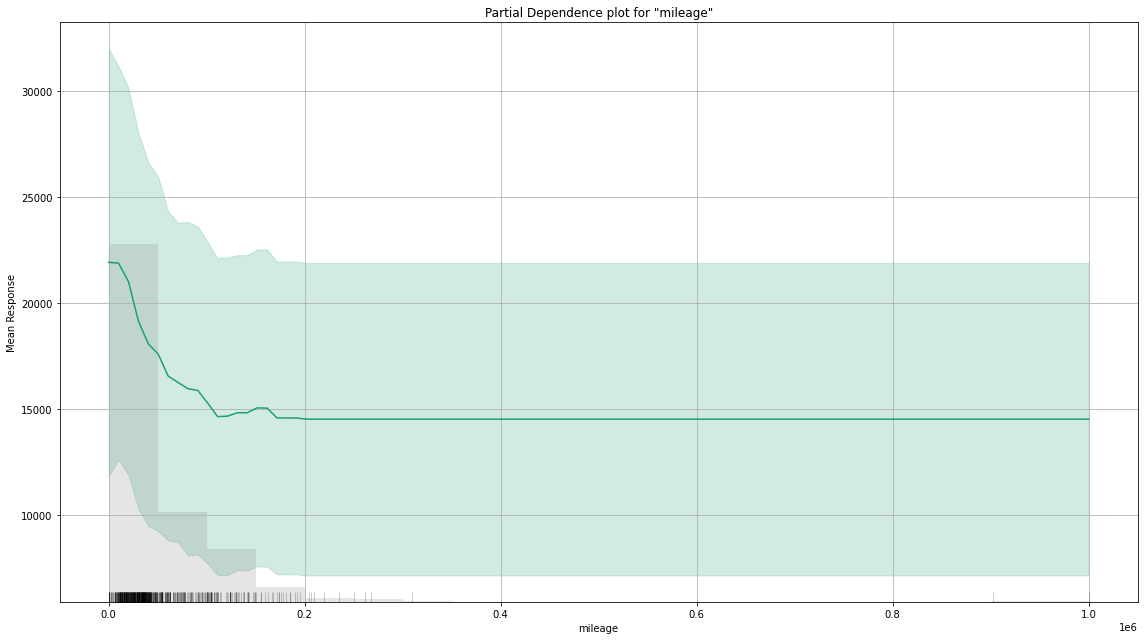

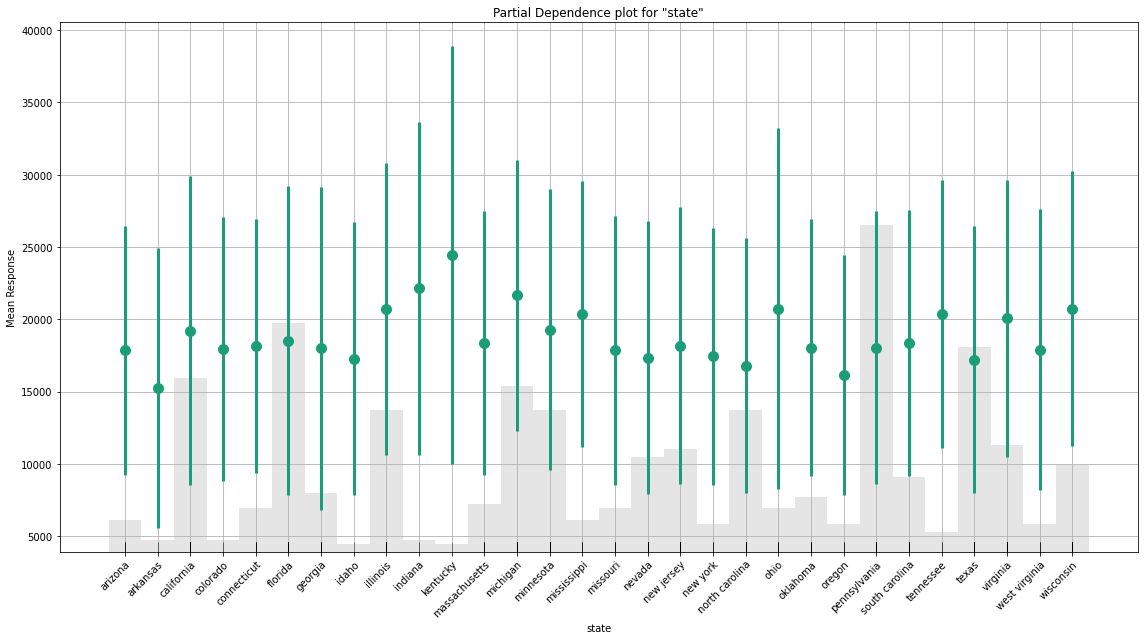

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

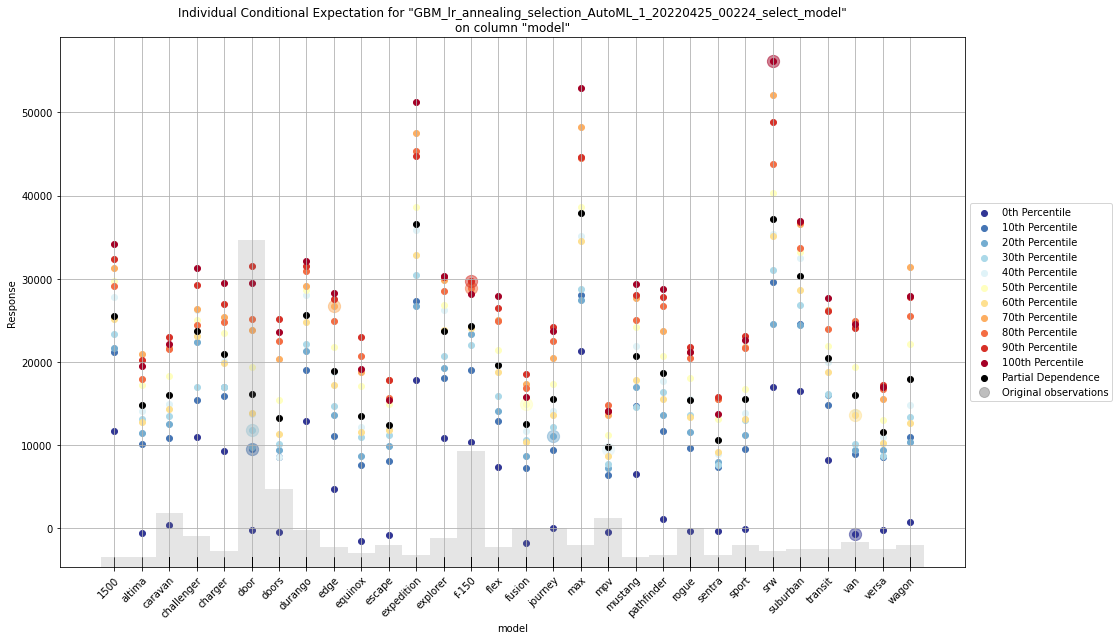

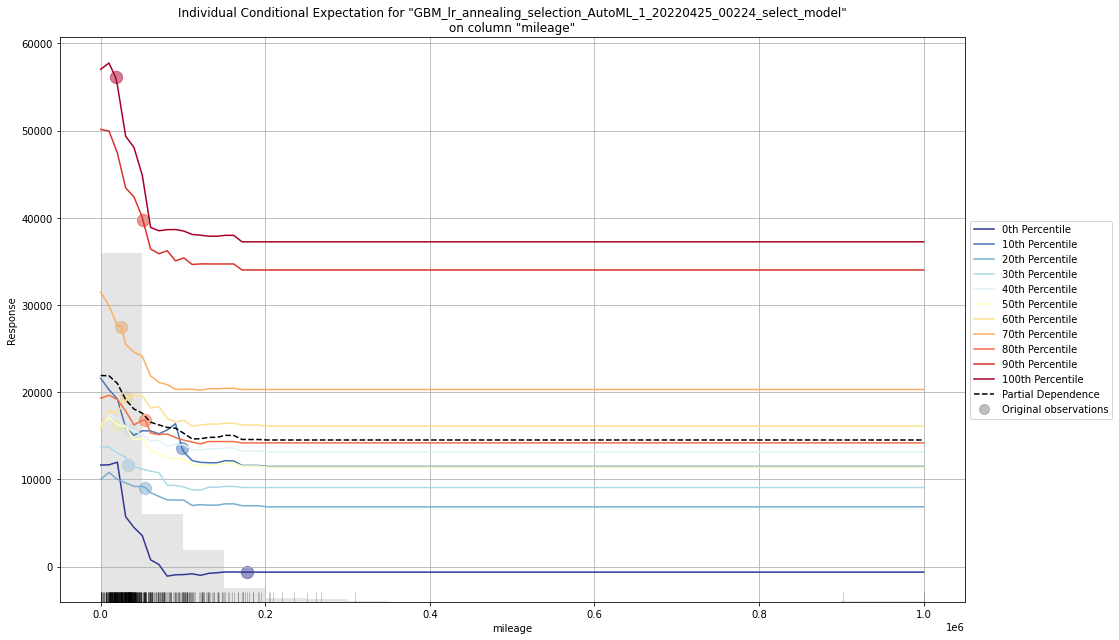

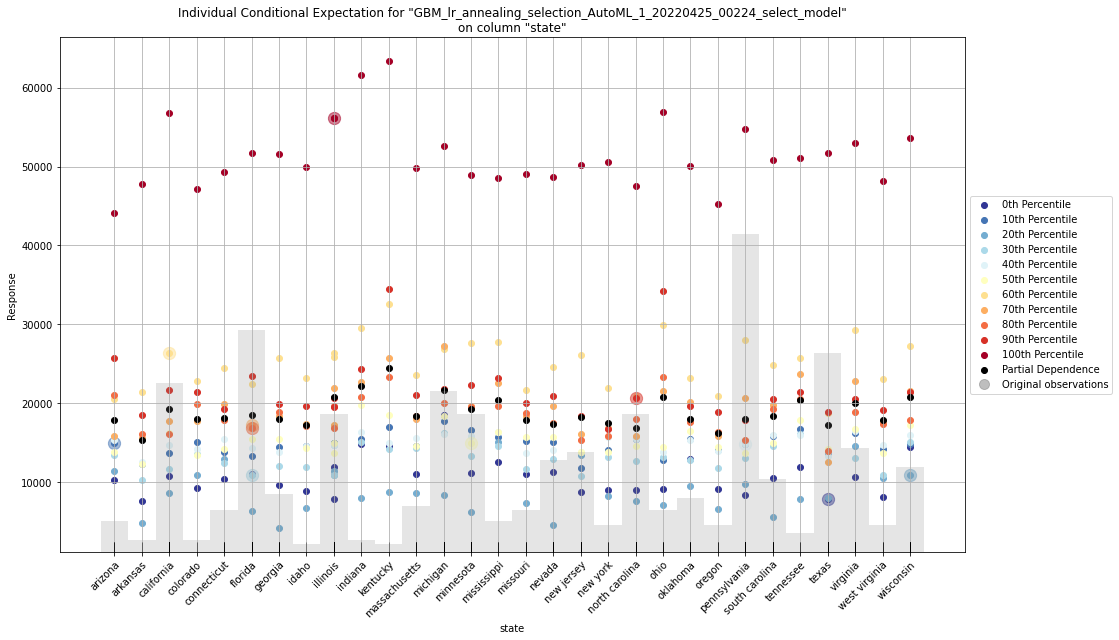

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [11]:

# Get H2O Model
model_h2o = h2o.get_model(df_output_info_gbm.reset_index()['model_id'][0])

# Explain whole test set using the top 3 features
model_h2o.explain(frame = df_h2o_test, top_n_features = 3)


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

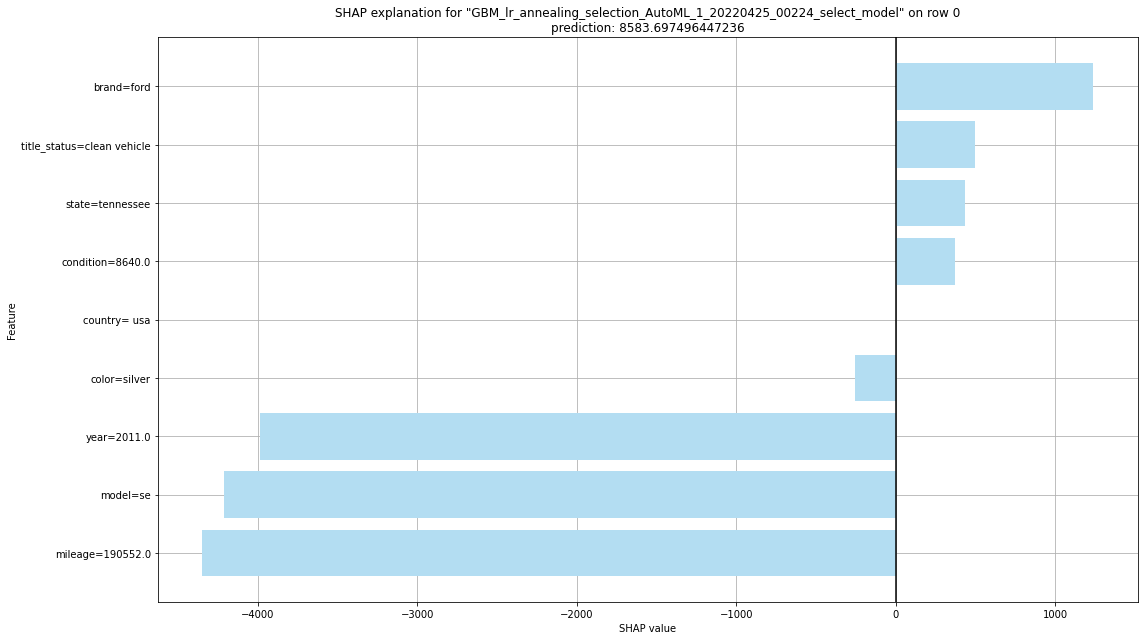

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

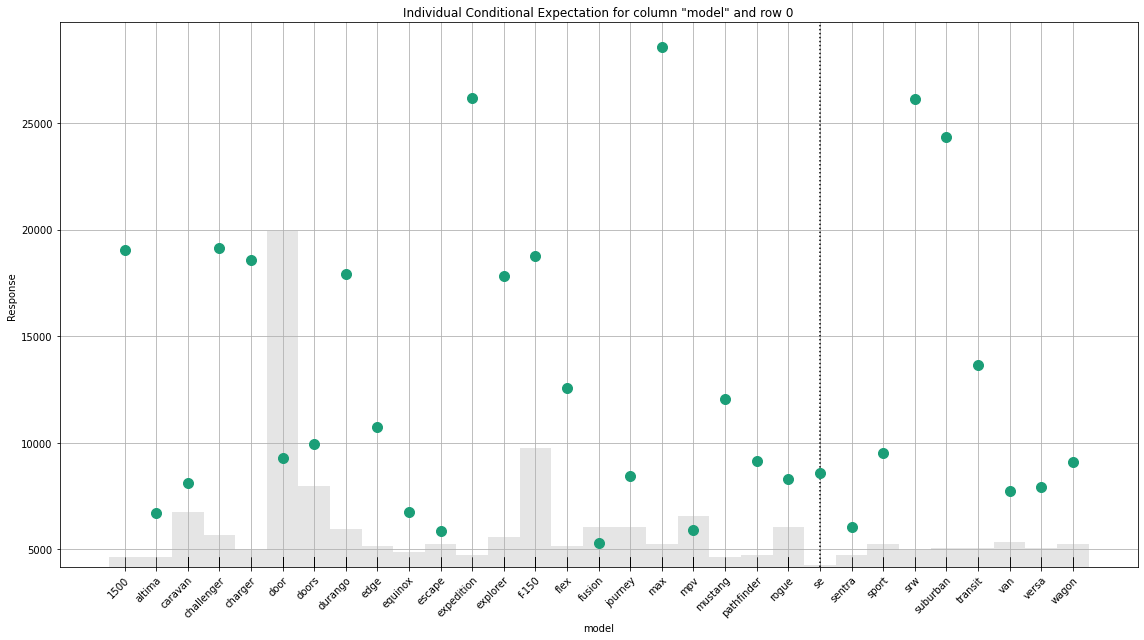

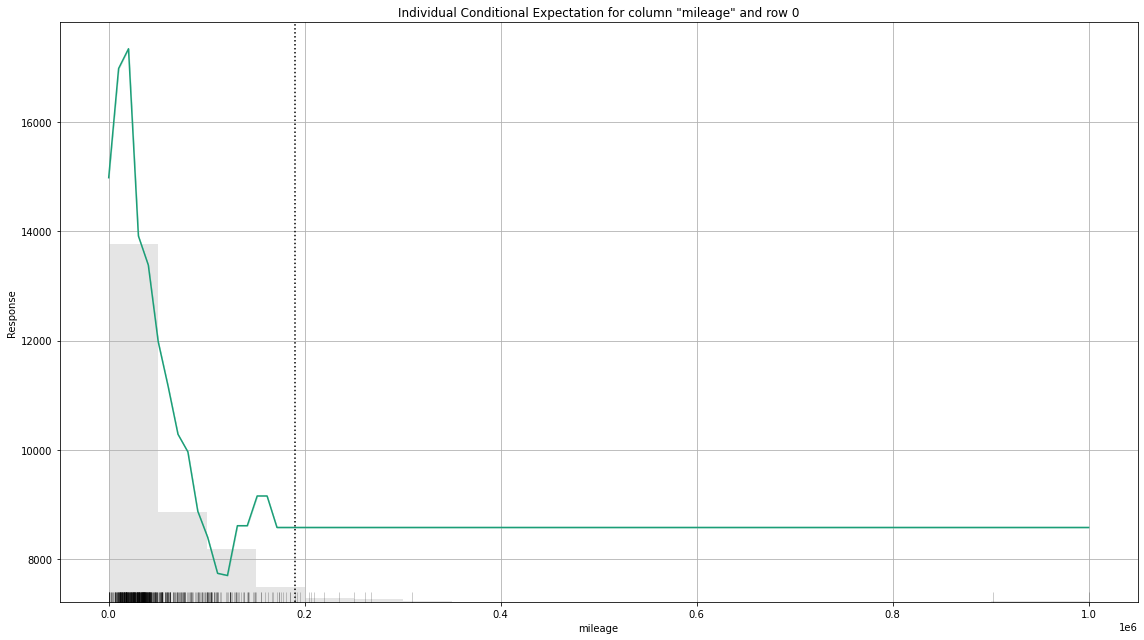

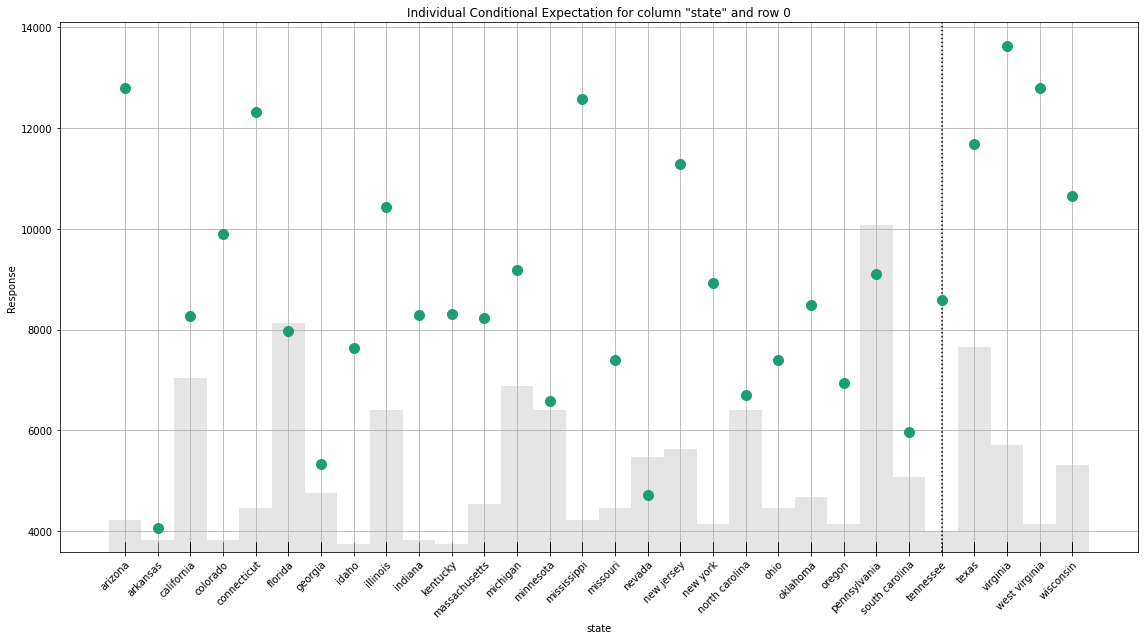

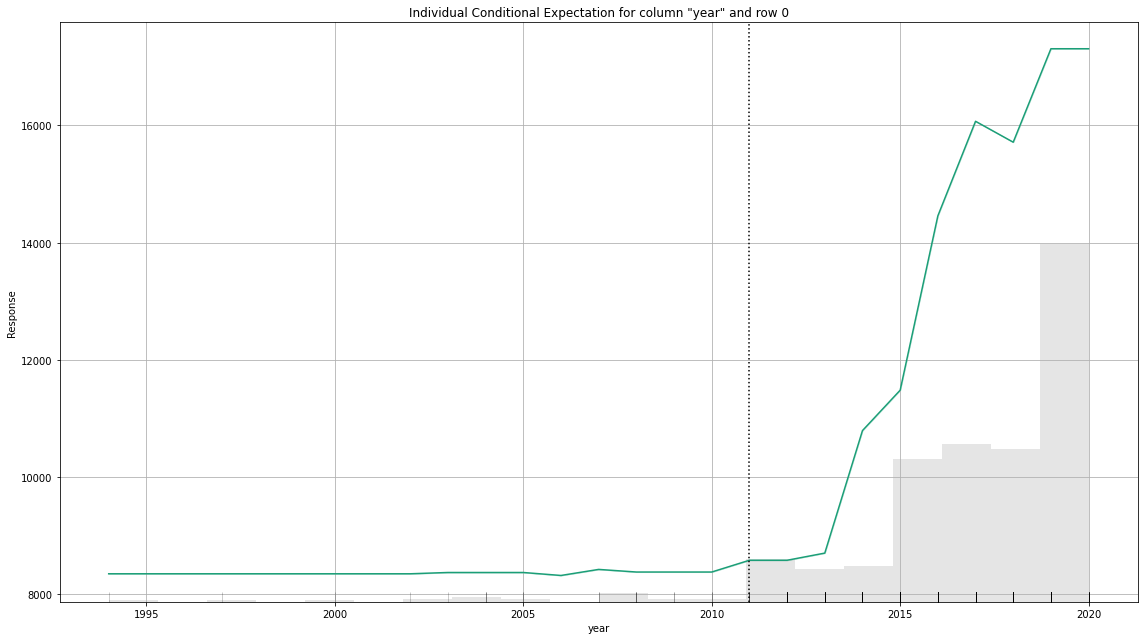

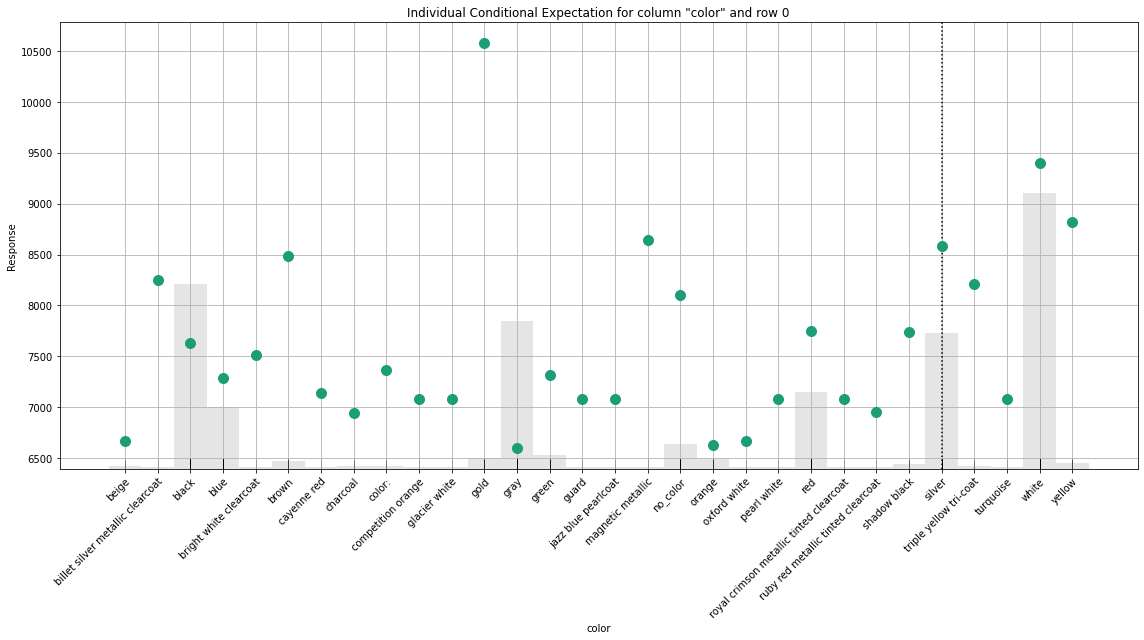

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

In [12]:

# Explain single row
model_h2o.explain_row(df_h2o_test, row_index=0)


# Top Model analysis - Learning curve plot

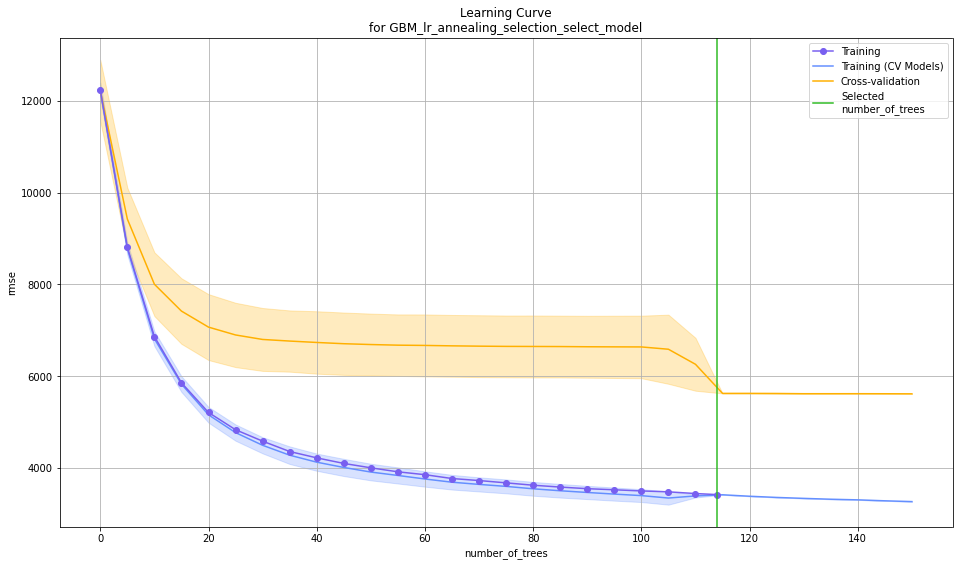

In [13]:

# Learning curve plot
model_h2o.learning_curve_plot()
